In [825]:
from keras.models import load_model
import pandas as pd
import numpy as np
from PIL import Image,ImageOps
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.patches as mpatches
import keras.backend as K
import tensorflow as tf
import os
import shutil
import cv2
import string
import sys
from IPython.display import Markdown as md

In [826]:
INPUT_IMAGE = './input/input_104.jpg'
SEGMENTED_OUTPUT_DIR = './segmented/'
EMNIST_PATH = './data/emnist/'
MODEL_PATH = './model/new_model.h5'
MAPPING_PROCESSED = EMNIST_PATH + 'processed-mapping_new.pkl'

In [827]:
#----------------Over ride FIX----------------#

directory = "segmented"   

parent_dir = "."     
shutil.rmtree('./segmented/')                       #Deletes the folder if existing files are present.
    
path = os.path.join(parent_dir, directory) 
os.makedirs(path)                                   #Makes a folder to save images

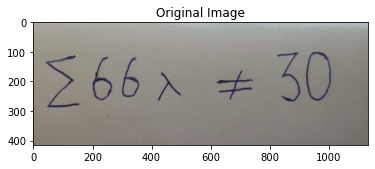

In [828]:
#Reading and displaying the original image

img = Image.open(INPUT_IMAGE)                                     #Reads image
plt.title("Original Image")
plt.imshow(img)                                                   #Prints image
img.close()

## Character Segmentation

In [829]:
OUTPUT_DIR = './segmented/'                       #Output directory
#------------------Functions------------------#

def line_array(array):
    list_x_upper = []
    list_x_lower = []
    for y in range(5, len(array) - 5):
        s_a, s_p = strtline(y, array)
        e_a, e_p = endline(y, array)
        if s_a >= 7 and s_p >= 5:
            list_x_upper.append(y)
            # print("list_x_upper",list_x_upper)
        if e_a >= 5 and e_p >= 7:
            list_x_lower.append(y)

    return list_x_upper, list_x_lower


def strtline(y, array):
    count_ahead = 0
    count_prev = 0
    for i in array[y:y+10]:
        if i > 3:
            count_ahead += 1
  
    for i in array[y-10:y]:
        if i==0:
            count_prev += 1 
 
    return count_ahead, count_prev

def endline(y, array):
    count_ahead = 0
    count_prev = 0
    for i in array[y:y+10]:
        if i==0:
            count_ahead += 1
  
    for i in array[y-10:y]:
        if i > 3:
            count_prev += 1
  
    return count_ahead, count_prev

input_image = INPUT_IMAGE
model_path = MODEL_PATH
mapping_processed = MAPPING_PROCESSED
MODEL_PATH1 = './model/alphanum_model_binary_ex_88.h5'
MODEL_PATH2 = './model/new_model_final.h5'
MAPPING_PROCESSED1 = EMNIST_PATH + 'processed-mapping_old.pkl'
MAPPING_PROCESSED2 = EMNIST_PATH + 'processed-mapping_new.pkl'

def endline_word(y, array, a):
    count_ahead = 0
    count_prev = 0
    for i in array[y:y+2*a]:
        if i < 2:
            count_ahead+= 1  
    for i in array[y-a:y]:
        if i > 2:
            count_prev += 1  
    return count_prev ,count_ahead

def end_line_array(array, a):
    list_endlines = []
    for y in range(len(array)):
        e_p, e_a = endline_word(y, array, a)
        # print(e_p, e_a)
        if e_a >= int(1.5*a) and e_p >= int(0.7*a):
            list_endlines.append(y)
    return list_endlines

def refine_endword(array):
    refine_list = []
    for y in range(len(array)-1):
        if array[y]+1 < array[y+1]:
            refine_list.append(array[y])

    if len(array) != 0:
        refine_list.append(array[-1])
    return refine_list

def conversion(parsed_str, ratio):
    for i in range(len(parsed_str)):
        if parsed_str[i] == 't':
            parsed_str[i] = '+'
    for i in range(len(list)):
         if ratio[i] > 5:
            parsed_str[i] = '1'

def refine_array(array_upper, array_lower):
    upperlines = []
    lowerlines = []
    for y in range(len(array_upper)-1):
        if array_upper[y] + 5 < array_upper[y+1]:
            upperlines.append(array_upper[y]-10)
    for y in range(len(array_lower)-1):
        if array_lower[y] + 5 < array_lower[y+1]:
            lowerlines.append(array_lower[y]+10)

    upperlines.append(array_upper[-1]-10)
    lowerlines.append(array_lower[-1]+10)

    return upperlines, lowerlines

def makearray(code2char):
    global parsed_str
    parsed_str = []
    for r in results:
        parsed_str += code2char[r] 


def add_par(parsed_str,list):
    list.insert((len(list) + 1), 'F')
    ab = 1
    for i in range(len(parsed_str)):
        if list[i+1] != list[i]:
            if list[i+1] == "T":
                parsed_str.insert(i + ab, "(")
                ab += 1
            else:
                parsed_str.insert(i + ab, ")")
                ab += 1
            
def add_exponent(parsed_str):
    global sq
    sq = []

    for i in range(len(parsed_str)):
        if parsed_str[i] == "(":
            sq.append("T")
        else:
            sq.append("F")
    ii = 0
    for i in range(len(sq)):         #Adding the square sign before the exponent
        if sq[i] == "T":
            parsed_str.insert(i+ii, "^")
            ii += 1
        

def slanted(parsed_str,letter):
    conversion(parsed_str, ratio)
    if (letter[0][1] - letter[size-1][1]) > 100:       #If equation is not in a straight line, exponent will not be detected
        print("#----------------------------------------#")
        print("   Image too slanted to detect squares  ")
        print("#----------------------------------------#")
        
def exponent_area_filter(maxarea, area):
    #----------------Exponent Detection----------------#    
    #2 layers of filteration are used. 1st layer detects squares by comparing area with base character and 2nd layer compares
    #y axis coordinate with base characters coordinate. If both conditions are met, square is confirmed.
    global perc, perca, list
    perca = []
    for i in range(size):
        perc = round(((maxarea - area[i]) / maxarea) * 100)
        perca.append(perc)                                 #Calculates percentage difference of each character with base character
    list = []

    for i in range(len(perca)):
        if perca[i] > 65: 
            list.insert(i,"T")                            #Creates a list identifying potential squares by comparing area.
        else :                                            #Potential exponents are True and other characters are False
            list.insert(i, "F")
            
def exponent_height_filter(letter,list):
    maxy = letter[maxindex][1] + letter[maxindex][3]                #Calculates y axis coordinate of base character

    for i in range(len(list)):
        if list[i] == 'T':
            diff = round(((maxy - (letter[i][1] + letter[i][3])) / maxy) * 100)    #calculates percentage difference through y axis
            if diff < 50:                    
                list[i] = 'F'
               
        
def calcarea(segmented_images):
    global area, ratio
    area = []
    ratio = []
    for i in range(size):
        h, w = segmented_images[i].size
        a = h*w
        rat = round(w/h)
        ratio.append(rat)
        area.append(a) 
        
def Final(parsed_str):
    global output
    output = ''
    for i in range(len(parsed_str)):
        output += parsed_str[i]              #Converts array to string
    print("Result : ", output)

def letter_width(contours):
    letter_width_sum = 0
    count = 0
    for cnt in contours:
        if cv2.contourArea(cnt) > 20:
            x,y,w,h = cv2.boundingRect(cnt)
            letter_width_sum += w
            count += 1

    return letter_width_sum/count


def end_wrd_dtct(lines, i, bin_img, mean_lttr_width, total_width):
    count_y = np.zeros(shape = total_width)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))              #CHANGES
    final_thr = cv2.morphologyEx(bin_img, cv2.MORPH_CLOSE, kernel)
    for x in range(total_width):
        for y in range(lines[i][0],lines[i][1]):
            if bin_img[y][x] == 255:
                count_y[x] += 1
                
    end_lines = end_line_array(count_y, int(mean_lttr_width))
    endlines = refine_endword(end_lines)
    for x in endlines:
        final_thr[lines[i][0]:lines[i][1], x] = 255

    return endlines

def get_letter_rect(k, contours):             # Helper function for properly identifying '=' symbol.
                                              # Initially it treats 2 dashes of 'sign' as separate contours, thus this
                                              # will help to identify and merge them into a single '=' contour                                              

    valid = True
    x,y,w,h = cv2.boundingRect(contours[k])
    for i in range(len(contours)):
        cnt = contours[i]
        if i == k:
            continue
        elif cv2.contourArea(cnt) < 50:
            continue

        x1,y1,w1,h1 = cv2.boundingRect(cnt)
        if abs(x1 + w1/2 - (x + w/2)) < 50:
            if y1 > y:
                h = abs(y - (y1 + h1))
                w = abs(x - (x1 + w1))
            else:
                valid = False
            break

    return (valid,x,y,w,h)

def CallModel(custom_objects={'focal_loss': categorical_focal_loss(gamma=2.0, alpha=0.25)}):
    global MODEL_PATH, MAPPING_PROCESSED, model
    input_image = INPUT_IMAGE.split('_')[1]
    input_image = input_image.split('.')[0]
    if int(input_image) < 90:
        MODEL_PATH = MODEL_PATH1
        MAPPING_PROCESSED = MAPPING_PROCESSED1
        model = load_model(MODEL_PATH)
    else:
        MODEL_PATH = MODEL_PATH2
        MAPPING_PROCESSED = MAPPING_PROCESSED2
        model = load_model(MODEL_PATH, custom_objects={'focal_loss': categorical_focal_loss(gamma=2.0, alpha=0.25)})


def letter_seg(lines_img, x_lines, i):
    copy_img = lines_img[i].copy()
    x_linescopy = x_lines[i].copy()
    letter_img = []
    letter_k = []

    contours, hierarchy = cv2.findContours(copy_img,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    for k in range(len(contours)):
        cnt = contours[k]
        if cv2.contourArea(cnt) < 50:
            continue
        valid,x,y,w,h = get_letter_rect(k, contours)
        if valid:
            letter_k.append((x,y,w,h))


    global letter 
    letter = sorted(letter_k, key=lambda student: student[0])
    word = 1
    letter_index = 0
    a = 0    
    for e in range(len(letter)):
        if(letter[e][0]<x_linescopy[0]):
            letter_index += 1
            if letter_index > 9:    #To keep segmented images in ascending order. Limit = 81 images
                a += 1
                letter_index = 0
                letter_index += 1
            letter_img_tmp = lines_img[i][letter[e][1]-5:letter[e][1]+letter[e][3]+5,letter[e][0]-5:letter[e][0]+letter[e][2]+5]
            letter_img = letter_img_tmp
            cv2.imwrite(OUTPUT_DIR+str(a+1)+'_'+str(word)+'_'+str(letter_index)+'.jpg', 255-letter_img)

        else:                       #If image width is less than 1320, we will resize.
            x_linescopy.pop(0)
            word += 1
            letter_index = 1
            if letter_index > 9:    #To keep segmented images in ascending order. Limit = 81 images
                a += 1
                letter_index = 0
                letter_index += 1
            letter_img_tmp = lines_img[i][letter[e][1]-5:letter[e][1]+letter[e][3]+5,letter[e][0]-5:letter[e][0]+letter[e][2]+5]
#                 letter_img = cv2.resize(letter_img_tmp, dsize =(28, 28), interpolation = cv2.INTER_AREA)
            letter_img = letter_img_tmp
            cv2.imwrite(OUTPUT_DIR+str(a+1)+'_'+str(word)+'_'+str(letter_index)+'.jpg', 255-letter_img)
def categorical_focal_loss(gamma=2.0, alpha=0.25):
    """
    Implementation of Focal Loss from the paper in multiclass classification
    Formula:
        loss = -alpha*((1-p)^gamma)*log(p)
    Parameters:
        alpha -- the same as wighting factor in balanced cross entropy
        gamma -- focusing parameter for modulating factor (1-p)
    Default value:
        gamma -- 2.0 as mentioned in the paper
        alpha -- 0.25 as mentioned in the paper
    """
    def focal_loss(y_true, y_pred):
        # Define epsilon so that the backpropagation will not result in NaN
        # for 0 divisor case
        epsilon = K.epsilon()
        # Add the epsilon to prediction value
        #y_pred = y_pred + epsilon
        # Clip the prediction value
        y_pred = K.clip(y_pred, epsilon, 1.0-epsilon)
        # Calculate cross entropy
        cross_entropy = -y_true*K.log(y_pred)
        # Calculate weight that consists of  modulating factor and weighting factor
        weight = alpha * y_true * K.pow((1-y_pred), gamma)
        # Calculate focal loss
        loss = weight * cross_entropy
        # Sum the losses in mini_batch
        loss = K.sum(loss, axis=1)
        return loss
    
    return focal_loss

CallModel(custom_objects={'focal_loss': categorical_focal_loss(gamma=2.0, alpha=0.25)})


#------------------/Functions-----------------#

def image_segmentation(filepath):
    # -------------Thresholding Image--------------#
    print("\n........Program Initiated.......\n")
    src_img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    orig_height, orig_width = src_img.shape

    print("\n Resizing Image........")
    width = 1320
    height = int(width * orig_height / orig_width)
    src_img = cv2.resize(src_img, dsize=(width, height), interpolation=cv2.INTER_AREA)

    print("#---------Image Info:--------#")
    print("\tHeight =", height, "\n\tWidth =", width)
    print("#----------------------------#")
    print("Applying Adaptive Threshold with kernel :- 21 X 21")

    PIXEL_SET = 255
    kernel_size = 21
    normalized_mean = 20
    bin_img = cv2.adaptiveThreshold(src_img, PIXEL_SET, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, kernel_size,
                                    normalized_mean)

    print("Noise Removal From Image.........")
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    final_thr = cv2.morphologyEx(bin_img, cv2.MORPH_CLOSE, kernel)
    contr_retrival = final_thr.copy()

    # -------------/Thresholding Image-------------#

    # -------------Line Detection------------------#
    print("Beginning Character Segmenation..............")
    count_x = np.zeros(shape=(height))
    for y in range(height):
        for x in range(width):
            if bin_img[y][x] == PIXEL_SET:
                count_x[y] += 1

    upper_lines, lower_lines = line_array(count_x)
    upperlines, lowerlines = refine_array(upper_lines, lower_lines)

    if len(upperlines) == len(lowerlines):
        lines = []
        for y in upperlines:
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))              #CHANGES
            final_thr[y][:] = PIXEL_SET
        for y in lowerlines:
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))              #CHANGES
            final_thr[y][:] = PIXEL_SET
        for y in range(len(upperlines)):
            lines.append((upperlines[y], lowerlines[y]))
    else:
        print("Too much noise in image, unable to process.\nPlease try with another image.")
        showimages()
        k = cv2.waitKey(0)
        while 1:
            k = cv2.waitKey(0)
            if k & 0xFF == ord('q'):
                cv2.destroyAllWindows()
                exit()

    lines = np.array(lines)
    no_of_lines = len(lines)
    print("\nGiven Text has ", no_of_lines, " no. of lines")

    lines_img = []
    for i in range(no_of_lines):
        lines_img.append(bin_img[lines[i][0]:lines[i][1], :])

    # -------------/Line Detection-----------------#

    # -------------Letter Width Calculation--------#

    contours, hierarchy = cv2.findContours(contr_retrival, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(src_img, contours, -1, (0, 255, 0), 1)

    mean_lttr_width = letter_width(contours)
    print("\nAverage Width of Each Letter : ", mean_lttr_width)

    # -------------/Letter Width Calculation-------#

    # --------------Word Detection-----------------#
    x_lines = []

    for i in range(len(lines_img)):
        x_lines.append(end_wrd_dtct(lines, i, bin_img, mean_lttr_width, width))

    for i in range(len(x_lines)):
        x_lines[i].append(width)

    # -------------/Word Detection-----------------#

    # -------------Letter Segmentation-------------#

    for i in range(len(lines)):
        letter_seg(lines_img, x_lines, i)

    # ------------\Letter Segmentation-------------#

    # -------------Character segmenting------------#

    contours, hierarchy = cv2.findContours(bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for cnt in contours:
        if cv2.contourArea(cnt) > 20:
            x, y, w, h = cv2.boundingRect(cnt)
            cv2.rectangle(src_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
# plt.imshow(src_img)
# plt.scatter(x,y+h)
            
    # -------------/Character segmenting-----------#

In [830]:
image_segmentation(INPUT_IMAGE)


........Program Initiated.......


 Resizing Image........
#---------Image Info:--------#
	Height = 483 
	Width = 1320
#----------------------------#
Applying Adaptive Threshold with kernel :- 21 X 21
Noise Removal From Image.........
Beginning Character Segmenation..............

Given Text has  1  no. of lines

Average Width of Each Letter :  99.71428571428571


In [831]:
segmented_images = []
files = [f for r, d, f in os.walk(SEGMENTED_OUTPUT_DIR)][0]            #Used to access the root of image
files.sort()
for f in files:
    segmented_images.append(Image.open(SEGMENTED_OUTPUT_DIR + f))       #Saves segmented images

Total images =  7


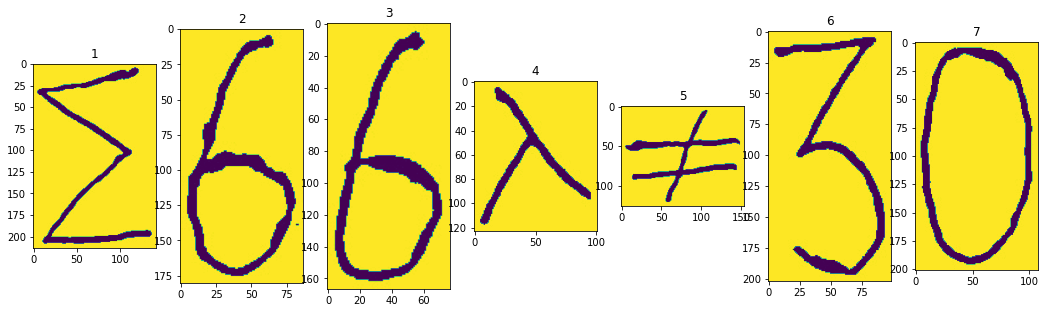

In [832]:
figure(figsize=(18,18))

size = len(segmented_images)
print("Total images = ", size)
i = 0
for i in range(size):
    img = segmented_images[i]
    plt.subplot(2, size, i + 1)                       #Plots segmented images 
    plt.title(i+1)
    plt.imshow(img)

## Converting Segmented Characters to EMNIST format

In [833]:
def img2emnist(filepath, char_code):
    img = Image.open(filepath).resize((28, 28))
    inv_img = ImageOps.invert(img)
    
    flatten = np.array(inv_img).flatten()
    flatten = flatten / 255.0
    flatten = np.where(flatten > 0.5, 1, 0)
    
    csv_img = ','.join([str(num) for num in flatten])
    csv_str = '{},{}'.format(char_code, csv_img)
    return csv_str

In [834]:
temp_filename = 'test.csv'
if os.path.exists(temp_filename):
    os.remove(temp_filename)

f_test = open(temp_filename, 'a+')
column_names = ','.join(["label"] + ["pixel" + str(i) for i in range(784)])
print(column_names, file=f_test)

files = [f for r, d, f in os.walk(SEGMENTED_OUTPUT_DIR)][0]
files.sort()
for f in files:
    csv = img2emnist(SEGMENTED_OUTPUT_DIR + f, -1)
    print(csv, file=f_test)
    
f_test.close()

In [835]:
test_df = pd.read_csv(temp_filename)
# test_df

## Character Recognition

In [836]:
data = pd.read_csv(temp_filename)
X_data = data.drop(labels = ["label"], axis = 1)
X_data = X_data.values.reshape(-1,28,28,1)

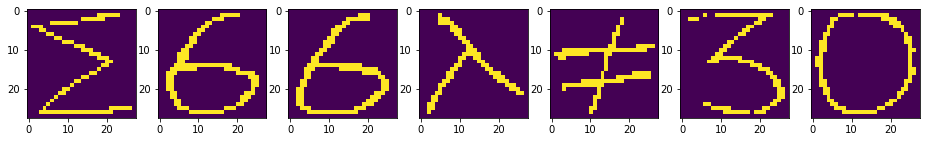

In [837]:
figure(figsize=(16,14))

size = X_data.shape[0]
for i in range(size):
    v = X_data[i][:,:,0].astype('uint8')
    img = Image.fromarray(255* v)
    
    plt.subplot(2, size, i + 1)
    plt.imshow(img)

In [838]:
df = pd.read_pickle(MAPPING_PROCESSED)
code2char = {}
for index, row in df.iterrows():
    code2char[row['id']] = row['char']

# Detecting exponent in function

In [841]:
calcarea(segmented_images)                                   #Calculates the Area of individual images

maxindex = np.argmax(area)
maxarea = area[maxindex]                                     #Calculates maximum area which is base character

exponent_area_filter(maxarea, area)                          #Any image 65% smaller to base chaacter is square positive
print("Square filter 1: ", list)                             #Prints 1st filter layer of square detection

exponent_height_filter(letter,list)                          #Any small image 50% higher of base character is square positive
print("Square filter 2: ", list)                              #Prints 2nd filter layer of square detection

Square filter 1:  ['F', 'F', 'F', 'F', 'F', 'F', 'F']
Square filter 2:  ['F', 'F', 'F', 'F', 'F', 'F', 'F']


In [842]:
results = model.predict(X_data)                              # Predict results
results = np.argmax(results, axis = 1)                       # Select the index with the maximum probability
 
makearray(code2char)
slanted(parsed_str,letter)
add_par(parsed_str,list)
add_exponent(parsed_str)
Final(parsed_str)

Result :  Σ66λ≠30
